In [1]:
# RNN(Long Short-Term Memory, LSTM)

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import os
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [83]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
from sklearn import preprocessing
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [65]:
def buildTrain(train, pastDay=30, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [9]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [10]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [101]:
def buildModel(shape):
    '''
    model = Sequential()
    model.add(LSTM(10,input_length=shape[1], input_dim=shape[2]))
    model.add(Dense(1,activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
    model.summary()
    return model
    '''
    '''
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(shape[1],shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(50, input_shape=(shape[1],shape[2]), return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(128,init='uniform',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(9,init='uniform',activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model
    '''
    
    model = Sequential([
    Dense(250, input_dim=shape[1]),
    Activation('relu'),
    Dense(250),
    Activation('relu'),
    Dense(9),
    Activation('softmax'),
    ])
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [21]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [106]:
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)


temp=train

#train=np.array(train)
train=normalize(train)
#train=pd.DataFrame(train)
#train=train.rename(columns = {0:'開盤價',1:'最高價',2:'最低價',3:'收盤價',4:'年',5:'月',6:'日',7:'第幾日'})

train_x1, train_y1 = buildTrain(train,1,1)
train_x2, train_y2 = buildTrain(temp,1,1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
#train_x1=normalize(train_x1)
#train_x1= np.reshape(train_x1, (train_x1.shape[0],1,train_x1.shape[1]))

train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)


train_x, train_y = shuffle1(train_x, train_y )
#print(train_x)
#print(train_y)

train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)


#train_x= np.reshape(train_x, (train_x.shape[0],train_x.shape[2]))
#val_x= np.reshape(val_x, (val_x.shape[0],val_x.shape[2]))

history = LossHistory()
model = buildModel(train_x.shape)




#callback = EarlyStopping(monitor="acc", patience=10, verbose=1, mode="auto")

#callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[history])



C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 250)               2250      
_________________________________________________________________
activation_17 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 250)               62750     
_________________________________________________________________
activation_18 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 9)                 2259      
_________________________________________________________________
activation_19 (Activation)   (None, 9)                 0         
Total params: 67,259
Trainable params: 67,259
Non-trainable params: 0
_________________________________________________________________
Train 

Epoch 84/300
 - 0s - loss: 1.6396 - acc: 0.3768 - val_loss: 1.8251 - val_acc: 0.3047
Epoch 85/300
 - 0s - loss: 1.6373 - acc: 0.3722 - val_loss: 1.8146 - val_acc: 0.3029
Epoch 86/300
 - 0s - loss: 1.6072 - acc: 0.3882 - val_loss: 1.7955 - val_acc: 0.3082
Epoch 87/300
 - 0s - loss: 1.6187 - acc: 0.3840 - val_loss: 1.7919 - val_acc: 0.3387
Epoch 88/300
 - 0s - loss: 1.6143 - acc: 0.3850 - val_loss: 1.7908 - val_acc: 0.3029
Epoch 89/300
 - 0s - loss: 1.5988 - acc: 0.3866 - val_loss: 1.7865 - val_acc: 0.3136
Epoch 90/300
 - 0s - loss: 1.5842 - acc: 0.4026 - val_loss: 1.7946 - val_acc: 0.3190
Epoch 91/300
 - 0s - loss: 1.5905 - acc: 0.3968 - val_loss: 1.7730 - val_acc: 0.3118
Epoch 92/300
 - 0s - loss: 1.5813 - acc: 0.3940 - val_loss: 1.7751 - val_acc: 0.3190
Epoch 93/300
 - 0s - loss: 1.5755 - acc: 0.3982 - val_loss: 1.7804 - val_acc: 0.3100
Epoch 94/300
 - 0s - loss: 1.5744 - acc: 0.4016 - val_loss: 1.7894 - val_acc: 0.3262
Epoch 95/300
 - 0s - loss: 1.5701 - acc: 0.3974 - val_loss: 1.788

Epoch 180/300
 - 0s - loss: 1.3515 - acc: 0.4859 - val_loss: 1.7846 - val_acc: 0.3315
Epoch 181/300
 - 0s - loss: 1.3635 - acc: 0.4786 - val_loss: 1.7805 - val_acc: 0.3441
Epoch 182/300
 - 0s - loss: 1.3616 - acc: 0.4809 - val_loss: 1.7692 - val_acc: 0.3154
Epoch 183/300
 - 0s - loss: 1.3481 - acc: 0.4879 - val_loss: 1.7449 - val_acc: 0.3387
Epoch 184/300
 - 0s - loss: 1.3340 - acc: 0.4921 - val_loss: 1.7639 - val_acc: 0.3405
Epoch 185/300
 - 0s - loss: 1.3493 - acc: 0.4865 - val_loss: 1.7687 - val_acc: 0.3262
Epoch 186/300
 - 0s - loss: 1.3455 - acc: 0.4897 - val_loss: 1.7816 - val_acc: 0.3333
Epoch 187/300
 - 0s - loss: 1.3495 - acc: 0.4837 - val_loss: 1.7734 - val_acc: 0.3315
Epoch 188/300
 - 0s - loss: 1.3314 - acc: 0.4943 - val_loss: 1.7779 - val_acc: 0.3262
Epoch 189/300
 - 0s - loss: 1.3358 - acc: 0.4931 - val_loss: 1.7695 - val_acc: 0.3208
Epoch 190/300
 - 0s - loss: 1.3253 - acc: 0.4987 - val_loss: 1.7913 - val_acc: 0.3405
Epoch 191/300
 - 0s - loss: 1.3406 - acc: 0.4973 - val

Epoch 276/300
 - 0s - loss: 1.2187 - acc: 0.5436 - val_loss: 1.8749 - val_acc: 0.3351
Epoch 277/300
 - 0s - loss: 1.2278 - acc: 0.5288 - val_loss: 1.8513 - val_acc: 0.3459
Epoch 278/300
 - 0s - loss: 1.2248 - acc: 0.5340 - val_loss: 1.9024 - val_acc: 0.3082
Epoch 279/300
 - 0s - loss: 1.2248 - acc: 0.5426 - val_loss: 1.8624 - val_acc: 0.3082
Epoch 280/300
 - 0s - loss: 1.2138 - acc: 0.5456 - val_loss: 1.8618 - val_acc: 0.3369
Epoch 281/300
 - 0s - loss: 1.2165 - acc: 0.5470 - val_loss: 1.8563 - val_acc: 0.3369
Epoch 282/300
 - 0s - loss: 1.2132 - acc: 0.5432 - val_loss: 1.8557 - val_acc: 0.3190
Epoch 283/300
 - 0s - loss: 1.2226 - acc: 0.5470 - val_loss: 1.8622 - val_acc: 0.3387
Epoch 284/300
 - 0s - loss: 1.2184 - acc: 0.5380 - val_loss: 1.8388 - val_acc: 0.3280
Epoch 285/300
 - 0s - loss: 1.2203 - acc: 0.5344 - val_loss: 1.9136 - val_acc: 0.3011
Epoch 286/300
 - 0s - loss: 1.2194 - acc: 0.5392 - val_loss: 1.8588 - val_acc: 0.3315
Epoch 287/300
 - 0s - loss: 1.2072 - acc: 0.5444 - val

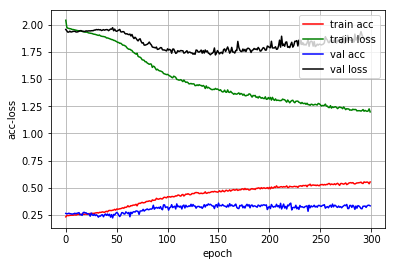

In [107]:
history.loss_plot('epoch')

In [108]:
loss, accuracy = model.evaluate(test_x, test_y)

print('test loss: ', loss)
print('test accuracy: ', accuracy)

618/618 [==============================] - 0s 50us/step
test loss:  1.8094034943380017
test accuracy:  0.3155339806789719
